# Data Exploration: **Do People with Different Ideologies Speak Differently?**


## **Mounting the Google Drive**

It is possible to mount your Google Drive to Colab if you need additional storage or if you need to use files from it. To do that run (click on play button or use keyboard shortcut 'Command/Ctrl+Enter') the following code cell:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1.   After running the cell, URL will appear.

2.   Following this URL, you will be redirected to the page where you need to choose Google Drive account to mount to.

3.   You will further be asked to give Google Drive Stream a permission to access the chosen Google account

4.   After granting the access, authorization code will be given to you

5.   Copy the authorization code into the dedicated textbox in Colab under '*Enter your authorization code:*' writing

After copying the authorization code, you should get the message saying '*Mounted at /content/gdrive*'

Path to the files from the mounted Drive will then be '/content/drive/MyDrive/'. By opening the Files tab (left sidebar, folder icon) you should also be able to see the accessible files.

## **Required Libraries**

In [2]:
!pip install qwikidata

In [3]:
import bz2
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy.stats as stats
from qwikidata.linked_data_interface import get_entity_dict_from_api

## **Load and Merge Preprocessed Data Into Single Dataframe**
The first step is to merge together all different parquet files from different year in a single dataframe. It will allow to work easily on it, and perform the entire analysis.<br>
After an initial analysis on the preprocessed data, it was noticed that further filtering operations were needed. All were performed in the same function loading the data, and are the following:
- drop quotations of politicians who switched parties during the time frame (about 14,11%). Considering them would have meant integrating also the time frame related to each political party "phase" (not necessary for our analysis);
- drop quotation with an unordered probability list (0,00092%);
- remove entries with speaker maximum probability < 0.6, in order to reduce uncertainty. This value could be changed in the future, depending on the analysis results.

In [4]:
file_path_2020 = '/content/drive/MyDrive/Quotebank_Repub_Dem/new-quotes-2020-repub-dem.parquet'
file_path_2019 = '/content/drive/MyDrive/Quotebank_Repub_Dem/new-quotes-2019-repub-dem.parquet'
file_path_2018 = '/content/drive/MyDrive/Quotebank_Repub_Dem/new-quotes-2018-repub-dem.parquet'
file_path_2017 = '/content/drive/MyDrive/Quotebank_Repub_Dem/new-quotes-2017-repub-dem.parquet'
file_path_2016 = '/content/drive/MyDrive/Quotebank_Repub_Dem/new-quotes-2016-repub-dem.parquet'
file_path_2015 = '/content/drive/MyDrive/Quotebank_Repub_Dem/new-quotes-2015-repub-dem.parquet'
file_path_final = '/content/drive/MyDrive/Quotebank_Repub_Dem/new-quotes-final-repub-dem.parquet'

prob_threshold = 0.6

# load preprocessed data and merge them in a single dataframe
def load_and_merge():
  # load
  df_20 = pd.read_parquet(file_path_2020)
  df_19 = pd.read_parquet(file_path_2019)
  df_18 = pd.read_parquet(file_path_2018)
  df_17 = pd.read_parquet(file_path_2017)
  df_16 = pd.read_parquet(file_path_2016)
  df_15 = pd.read_parquet(file_path_2015)

  # merge into single dataframe
  df = pd.concat([df_20, df_19, df_18, df_17, df_16, df_15], ignore_index=True)

  # delete unused variables for garbage collector
  del df_20
  del df_19
  del df_18
  del df_17
  del df_16
  del df_15

  # remove entries with more then 1 party
  df = df[df["party"].apply(len) == 1]

  # remove entries where the speaker with maximum probability is not the first in the list
  max_prob_speaker = df['probas'].apply(lambda x: x[0][0])
  df['max_prob_speaker'] = max_prob_speaker
  df = df[df["speaker"] == df['max_prob_speaker']]

  # remove entries with best speaker probability less the 0.6
  max_probas = df['probas'].apply(lambda x: x[0][1])
  df['max_probas'] = max_probas.astype(float)
  df = df[df["max_probas"] > prob_threshold]

  # remove added columns
  #df = df.drop(["max_probas", "max_prob_speaker"], axis=1)

  return df

# Load and merge into a single dataframe
df = load_and_merge()
df

,quoteID,quotation,speaker,qids,probas,gender,occupation,party,max_prob_speaker,max_probas
0,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,Q367796,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy...",[Q6581072],[Q82955],[Q29468],Sue Myrick,0.8867
9,2020-01-26-000499,a few of the candidates who will do better in ...,Dave Loebsack,Q771586,"[[Dave Loebsack, 0.9011], [None, 0.0949], [Joe...",[Q6581097],"[Q82955, Q1622272, Q1238570]",[Q29552],Dave Loebsack,0.9011
10,2020-01-26-040663,"The generational thing is important, quite hon...",Dave Loebsack,Q771586,"[[Dave Loebsack, 0.7419], [None, 0.2133], [Pet...",[Q6581097],"[Q82955, Q1622272, Q1238570]",[Q29552],Dave Loebsack,0.7419
12,2020-01-09-060095,"No, are you kidding? The way that this place l...",Debbie Lesko,Q16731415,"[[Debbie Lesko, 0.7444], [None, 0.2323], [Pres...",[Q6581072],[Q82955],[Q29468],Debbie Lesko,0.7444
14,2020-01-30-029113,I actually believe that we do need to change t...,Julián Castro,Q970720,"[[Julián Castro, 0.9028], [None, 0.0972]]",[Q6581097],"[Q82955, Q40348]",[Q29552],Julián Castro,0.9028
...,...,...,...,...,...,...,...,...,...,...
7681437,2015-10-07-024138,For them to come back sends a message that we'...,Steve Tumlin,Q7614169,"[[Steve Tumlin, 0.7326], [None, 0.2674]]",[Q6581097],[Q82955],[Q29468],Steve Tumlin,0.7326
7681438,2015-03-14-008824,"From the beginning, the whole issue has had hi...",Jamie Raskin,Q640835,"[[Jamie Raskin, 0.661], [None, 0.2843], [Jim O...",[Q6581097],"[Q82955, Q1622272]",[Q29552],Jamie Raskin,0.6610
7681439,2015-10-17-014629,He [ Hansen ] was writing that grant while he ...,Teresa Fedor,Q7702134,"[[Teresa Fedor, 0.7461], [None, 0.1156], [Rich...",[Q6581072],[Q82955],[Q29552],Teresa Fedor,0.7461
7681440,2015-06-19-015086,help stop profitable multinationals from engag...,Carl Levin,Q444652,"[[Carl Levin, 0.8162], [None, 0.1838]]",[Q6581097],"[Q82955, Q40348]",[Q29552],Carl Levin,0.8162


Text(0, 0.5, 'Number of Speakers')

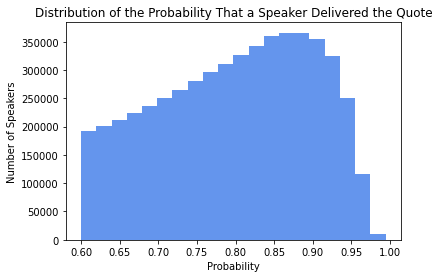

In [6]:
# Plot the distribution of the speakers' probabilities
df['max_probas'] = df['max_probas'].astype(float) # transform the string values into float
ax = df['max_probas'].plot.hist(bins=20, color = 'cornflowerblue')
ax.set_title('Distribution of the Probability That a Speaker Delivered the Quote')
ax.set_xlabel("Probability")
ax.set_ylabel("Number of Speakers")


In [7]:
# Add number of quotations per qid to dataframe (Caution: this column is already aggregated)
df['quotationCounts'] = df.groupby(['qids'])['quoteID'].transform("count")

In [8]:
republican_qid = 'Q29468'
democrats_qid = 'Q29552'
republicans_df = df.loc[df['party'].str[0] == republican_qid] #People from the republican party
democrats_df = df.loc[df['party'].str[0] == democrats_qid] #People from the democratic party

In [9]:
# Number of of quotations per qid for republicans
n_quotes_per_qid_repub = republicans_df.groupby(['qids'])['quotationCounts'].mean()
n_quotes_per_qid_repub.describe()

count     7927.000000
mean       318.935789
std       1496.761344
min          1.000000
25%         11.000000
50%         48.000000
75%        177.000000
max      35694.000000
Name: quotationCounts, dtype: float64

In [10]:
# Number of of quotations per qid for democrats
n_quotes_per_qid_demo = democrats_df.groupby(['qids'])['quotationCounts'].mean()
n_quotes_per_qid_demo.describe()

count      7899.000000
mean        349.190657
std        1991.496176
min           1.000000
25%          10.000000
50%          49.000000
75%         193.000000
max      118912.000000
Name: quotationCounts, dtype: float64

The number of speakers of the Republican party (7927) and the number of speakers of the Democratic party (7899) is almost the same. 

Text(0, 0.5, 'Number of Speakers')

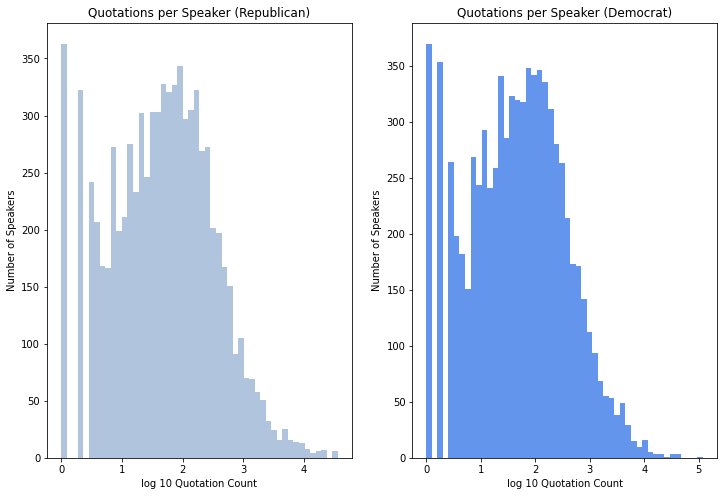

In [11]:
# Visualize the number of quotations per speaker grouped by Democrats and Republicans
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

subplot = axes[0];
subplot.hist(np.log10(n_quotes_per_qid_repub), bins = 50, color = 'lightsteelblue')
subplot.set_title('Quotations per Speaker (Republican)')
subplot.set_xlabel('log 10 Quotation Count')
subplot.set_ylabel('Number of Speakers')


subplot = axes[1];
subplot.hist(np.log10(n_quotes_per_qid_demo), bins = 50, color = 'cornflowerblue')
subplot.set_title('Quotations per Speaker (Democrat)')
subplot.set_xlabel('log 10 Quotation Count')
subplot.set_ylabel('Number of Speakers')


In [12]:
# Top speakers of the Democratic Party
n_quotes_per_qid_demo.sort_values(ascending=False)

qids
Q76          118912
Q6279         42902
Q170581       40580
Q11673        37313
Q434706       36874
              ...  
Q6134388          1
Q6133705          1
Q6133121          1
Q6132468          1
Q16187065         1
Name: quotationCounts, Length: 7899, dtype: int64

In [13]:
# Top speakers of the Republican Party
n_quotes_per_qid_repub.sort_values(ascending=False)

qids
Q473239      35694
Q24313       35650
Q22212       35365
Q2036942     34682
Q324546      32509
             ...  
Q363976          1
Q363972          1
Q34911531        1
Q3258787         1
Q1017083         1
Name: quotationCounts, Length: 7927, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


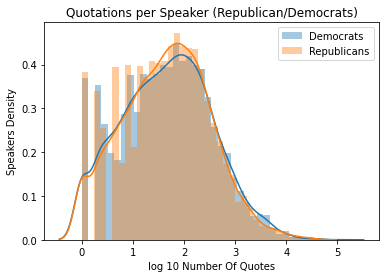

In [14]:
ax = sns.distplot(np.log10(n_quotes_per_qid_demo), hist=True, label='Democrats');
ax = sns.distplot(np.log10(n_quotes_per_qid_repub), hist=True, label='Republicans')
ax.set(title='Quotations per Speaker (Republican/Democrats)',xlabel='log 10 Number Of Quotes', ylabel='Speakers Density')
plt.legend()
plt.show()

## **Distribution of Male/Female Speaker within Each Political Party**

In [15]:
female_qid = 'Q6581072'
male_qid = 'Q6581097'
# Let's start with the Republicans
repub_females = republicans_df[republicans_df['gender'].str[0] == female_qid ]
repub_females.describe()

,max_probas,quotationCounts
count,418644.000000,418644.000000
mean,0.795721,4758.786415
std,0.097809,6093.054274
min,0.600100,1.000000
25%,0.717500,451.000000
50%,0.805500,1723.000000
75%,0.877500,6763.000000
max,0.986700,20259.000000


In [16]:
repub_males = republicans_df[republicans_df['gender'].str[0] == male_qid ]
repub_males.describe()

,max_probas,quotationCounts
count,2.099264e+06,2.099264e+06
mean,7.965755e-01,7.854988e+03
std,9.926443e-02,1.058324e+04
min,6.001000e-01,1.000000e+00
25%,7.167000e-01,5.750000e+02
50%,8.052000e-01,2.529000e+03
75%,8.799000e-01,1.036200e+04
max,9.941000e-01,3.569400e+04


In [17]:
female_male_quotes_fraction_repub = len(repub_females)/len(republicans_df)*100
print(f'only {female_male_quotes_fraction_repub:.2f} % of the republican quotes are delivered from women')

only 16.56 % of the republican quotes are delivered from women


In [18]:
# Let's do the same analysis with the democrats
democrats_females = democrats_df[democrats_df['gender'].str[0] == female_qid ]
democrats_females

,quoteID,quotation,speaker,qids,probas,gender,occupation,party,max_prob_speaker,max_probas,quotationCounts
124,2020-01-11-002445,And help he always did. For someone who prefer...,Anna Wintour,Q230744,"[[Anna Wintour, 0.9198], [None, 0.0802]]",[Q6581072],"[Q1930187, Q5436767, Q36180, Q1607826]",[Q29552],Anna Wintour,0.9198,1809
125,2020-04-06-004609,"As we are learning from health officials, this...",Anna Wintour,Q230744,"[[Anna Wintour, 0.8864], [None, 0.0901], [Chan...",[Q6581072],"[Q1930187, Q5436767, Q36180, Q1607826]",[Q29552],Anna Wintour,0.8864,1809
127,2020-03-16-057162,The Museum will remain closed through Saturday...,Anna Wintour,Q230744,"[[Anna Wintour, 0.7464], [None, 0.2536]]",[Q6581072],"[Q1930187, Q5436767, Q36180, Q1607826]",[Q29552],Anna Wintour,0.7464,1809
128,2020-03-16-022059,I have been impressed with the wider field of ...,Anna Wintour,Q230744,"[[Anna Wintour, 0.6585], [None, 0.2532], [MICH...",[Q6581072],"[Q1930187, Q5436767, Q36180, Q1607826]",[Q29552],Anna Wintour,0.6585,1809
129,2020-01-23-005418,And I think we've come to a time where we are ...,Sheila Oliver,Q7493177,"[[Sheila Oliver, 0.9228], [None, 0.0772]]",[Q6581072],[Q82955],[Q29552],Sheila Oliver,0.9228,598
...,...,...,...,...,...,...,...,...,...,...,...
7681407,2015-09-21-002169,a fun night. It's really a pleasure. I'm proud...,RoseLee Vincent,Q16886353,"[[RoseLee Vincent, 0.6406], [None, 0.3054], [D...",[Q6581072],[Q82955],[Q29552],RoseLee Vincent,0.6406,292
7681424,2015-04-28-005974,But I think the important thing about our case...,Dana Nessel,Q58333624,"[[Dana Nessel, 0.8034], [None, 0.1966]]",[Q6581072],[Q82955],[Q29552],Dana Nessel,0.8034,2002
7681436,2015-03-04-018543,For the sake of those people who are taking ca...,Jessyn Farrell,Q6187944,"[[Jessyn Farrell, 0.8084], [None, 0.115], [Liz...",[Q6581072],[Q82955],[Q29552],Jessyn Farrell,0.8084,201
7681439,2015-10-17-014629,He [ Hansen ] was writing that grant while he ...,Teresa Fedor,Q7702134,"[[Teresa Fedor, 0.7461], [None, 0.1156], [Rich...",[Q6581072],[Q82955],[Q29552],Teresa Fedor,0.7461,297


In [19]:
democrats_males = democrats_df[democrats_df['gender'].str[0] == male_qid ]
democrats_males

,quoteID,quotation,speaker,qids,probas,gender,occupation,party,max_prob_speaker,max_probas,quotationCounts
9,2020-01-26-000499,a few of the candidates who will do better in ...,Dave Loebsack,Q771586,"[[Dave Loebsack, 0.9011], [None, 0.0949], [Joe...",[Q6581097],"[Q82955, Q1622272, Q1238570]",[Q29552],Dave Loebsack,0.9011,1113
10,2020-01-26-040663,"The generational thing is important, quite hon...",Dave Loebsack,Q771586,"[[Dave Loebsack, 0.7419], [None, 0.2133], [Pet...",[Q6581097],"[Q82955, Q1622272, Q1238570]",[Q29552],Dave Loebsack,0.7419,1113
14,2020-01-30-029113,I actually believe that we do need to change t...,Julián Castro,Q970720,"[[Julián Castro, 0.9028], [None, 0.0972]]",[Q6581097],"[Q82955, Q40348]",[Q29552],Julián Castro,0.9028,6947
16,2020-01-06-052782,She has got a great team over there. She is fa...,Julián Castro,Q970720,"[[Julián Castro, 0.6826], [None, 0.1977], [Eli...",[Q6581097],"[Q82955, Q40348]",[Q29552],Julián Castro,0.6826,6947
17,2020-01-05-025623,"Obviously, a message that some people responde...",Julián Castro,Q970720,"[[Julián Castro, 0.8279], [None, 0.1651], [Ber...",[Q6581097],"[Q82955, Q40348]",[Q29552],Julián Castro,0.8279,6947
...,...,...,...,...,...,...,...,...,...,...,...
7681426,2015-09-09-015309,"Clearly, we must continue working to eliminate...",Tom Torlakson,Q7817857,"[[Tom Torlakson, 0.7516], [None, 0.2484]]",[Q6581097],[Q82955],[Q29552],Tom Torlakson,0.7516,1008
7681427,2015-12-14-014287,"Comfortable and Fair Flights Act of 2015,",Dan Lipinski,Q518424,"[[Dan Lipinski, 0.809], [None, 0.191]]",[Q6581097],"[Q82955, Q1622272, Q1622272, Q1622272]",[Q29552],Dan Lipinski,0.8090,820
7681435,2015-03-25-018635,"For the sake of safety, commerce, and recreati...",Sanford Bishop,Q983428,"[[Sanford Bishop, 0.657], [None, 0.2482], [Mar...",[Q6581097],"[Q82955, Q40348]",[Q29552],Sanford Bishop,0.6570,425
7681438,2015-03-14-008824,"From the beginning, the whole issue has had hi...",Jamie Raskin,Q640835,"[[Jamie Raskin, 0.661], [None, 0.2843], [Jim O...",[Q6581097],"[Q82955, Q1622272]",[Q29552],Jamie Raskin,0.6610,2276


In [20]:
female_male_quotes_fraction_demo = len(democrats_females)/len(democrats_df)*100
print(f' {female_male_quotes_fraction_demo:.2f} % of the democrats quotes are delivered from women')

 34.50 % of the democrats quotes are delivered from women


In [21]:
n_quotes_female_per_qid_demo = democrats_females.groupby(['qids'])['quotationCounts'].mean()
n_quotes_female_per_qid_repub = repub_females.groupby(['qids'])['quotationCounts'].mean()
n_quotes_male_per_qid_demo = democrats_males.groupby(['qids'])['quotationCounts'].mean()
n_quotes_male_per_qid_repub = repub_males.groupby(['qids'])['quotationCounts'].mean()

In [22]:
n_quotes_female_per_qid_demo.describe()

count     2601.000000
mean       365.859669
std       1532.438884
min          1.000000
25%         14.000000
50%         63.000000
75%        219.000000
max      40580.000000
Name: quotationCounts, dtype: float64

In [23]:
n_quotes_female_per_qid_repub.describe()

count     1534.000000
mean       272.910039
std       1106.814930
min          1.000000
25%         11.000000
50%         48.000000
75%        167.000000
max      20259.000000
Name: quotationCounts, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


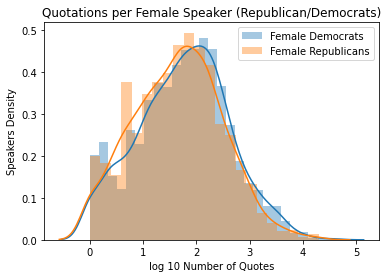

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


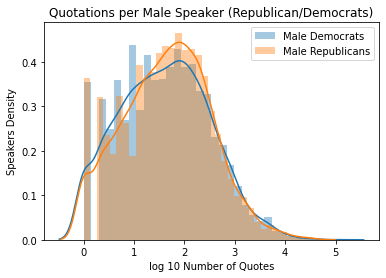

In [24]:
# Visualize quotations per speaker by same gender and different party
ax = sns.distplot(np.log10(n_quotes_female_per_qid_demo), hist=True, label='Female Democrats');
ax = sns.distplot(np.log10(n_quotes_female_per_qid_repub), hist=True, label='Female Republicans')
ax.set(title='Quotations per Female Speaker (Republican/Democrats)',xlabel='log 10 Number of Quotes', ylabel='Speakers Density')
plt.legend()
plt.show()

ax2 = sns.distplot(np.log10(n_quotes_male_per_qid_demo), hist=True, label='Male Democrats');
ax2 = sns.distplot(np.log10(n_quotes_male_per_qid_repub), hist=True, label='Male Republicans')
ax2.set(title='Quotations per Male Speaker (Republican/Democrats)',xlabel='log 10 Number of Quotes', ylabel='Speakers Density')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


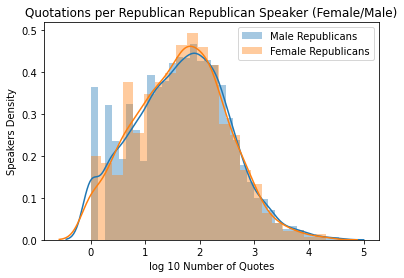

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


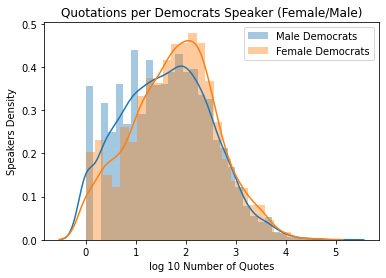

In [25]:
# Visualize quotations per speaker by different gender and same party
ax = sns.distplot(np.log10(n_quotes_male_per_qid_repub), hist=True, label='Male Republicans');
axes = sns.distplot(np.log10(n_quotes_female_per_qid_repub), hist=True, label='Female Republicans')
ax.set(title='Quotations per Republican Republican Speaker (Female/Male)',xlabel='log 10 Number of Quotes', ylabel='Speakers Density')
plt.legend()
plt.show()
ax2 = sns.distplot(np.log10(n_quotes_male_per_qid_demo), hist=True, label='Male Democrats');
ax2 = sns.distplot(np.log10(n_quotes_female_per_qid_demo), hist=True, label='Female Democrats')
ax2.set(title='Quotations per Democrats Speaker (Female/Male)',xlabel='log 10 Number of Quotes', ylabel='Speakers Density')
plt.legend()
plt.show()

## **How to Extract Information From qid**


In [26]:
# Extract information from qid
# from qwikidata.linked_data_interface import get_entity_dict_from_api
def extract_value_from_qid(qid):
  '''
  qid = string
  '''
  q_dict = get_entity_dict_from_api(qid)
  return q_dict['aliases']['en'][0]['value']

In [27]:
extract_value_from_qid(female_qid)

'woman'

## Sample Topic: **Climate Change**

In [36]:
# Only get quotes that contain key vocabulary related to climate change
# Vocabulary list extracted from https://www.health.state.mn.us/communities/environment/climate/docs/film/vocab_list.pdf
df['climate_change_voc'] = df['quotation'].str.findall('climate change|ecosystem|habitat|atmosphere|weather|precipitation|climate|global climate|\
fossil fuel| coal | oil |natural gas|greenhouse gas|water vapor|carbon dioxide|methane|ozone|ultraviolet radioation|greenhouse effect|global warming|\
adaptation|mitigation|carbon footprint|renewable resource|extreme weather event|drought|infectious disease|invasive species|pollutant|allergen|asthma', flags=re.IGNORECASE)

In [38]:
df_climate_change = df[df['climate_change_voc'].apply(lambda x: len(x)) > 0]
df_climate_change

,quoteID,quotation,speaker,qids,probas,gender,occupation,party,max_prob_speaker,max_probas,quotationCounts,climate_change_voc
17,2020-01-05-025623,"Obviously, a message that some people responde...",Julián Castro,Q970720,"[[Julián Castro, 0.8279], [None, 0.1651], [Ber...",[Q6581097],"[Q82955, Q40348]",[Q29552],Julián Castro,0.8279,6947,[ecosystem]
38,2020-03-27-028836,is poised to reverse course on state climate p...,Gavin Newsom,Q461391,"[[Gavin Newsom, 0.7522], [None, 0.2478]]",[Q6581097],"[Q82955, Q3427922, Q43845]",[Q29552],Gavin Newsom,0.7522,12705,[climate]
142,2020-02-03-092855,"We discussed ways, too, to further improve the...",Mike Pompeo,Q473239,"[[Mike Pompeo, 0.8043], [None, 0.1655], [Abdul...",[Q6581097],"[Q40348, Q43845, Q2961975, Q189290, Q82955]",[Q29468],Mike Pompeo,0.8043,35694,[climate]
157,2020-02-18-014398,cutting off (Venezuelan President Nicolas) Mad...,Mike Pompeo,Q473239,"[[Mike Pompeo, 0.711], [Jorge Arreaza, 0.2204]...",[Q6581097],"[Q40348, Q43845, Q2961975, Q189290, Q82955]",[Q29468],Mike Pompeo,0.7110,35694,[ oil ]
1406,2020-02-07-111676,We will need to work with China to advance som...,Elizabeth Warren,Q434706,"[[Elizabeth Warren, 0.8668], [None, 0.1299], [...",[Q6581072],"[Q185351, Q82955, Q37226, Q1622272, Q40348, Q1...",[Q29552],Elizabeth Warren,0.8668,36874,[climate]
...,...,...,...,...,...,...,...,...,...,...,...,...
7680840,2015-02-01-029765,"Now, all coal has to be scrubbed so why buy th...",Jim Bunn,Q1689051,"[[Jim Bunn, 0.7529], [None, 0.2471]]",[Q6581097],[Q82955],[Q29468],Jim Bunn,0.7529,48,"[ coal , coal ]"
7681054,2015-03-06-037886,"I'm not really surprised, considering the weat...",Dan Dodd,Q5213385,"[[Dan Dodd, 0.9388], [None, 0.0612]]",[Q6581097],[Q82955],[Q29552],Dan Dodd,0.9388,21,[weather]
7681325,2015-12-10-086303,Our sense is that ISIL is taking its profits b...,Adam Szubin,Q28514306,"[[Adam Szubin, 0.6549], [None, 0.3372], [Abu S...",[Q6581097],[Q82955],[Q29552],Adam Szubin,0.6549,353,[ oil ]
7681348,2015-09-28-097756,The Spirit of the Sound will aid The Maritime ...,Bob Duff,Q16213499,"[[Bob Duff, 0.7904], [None, 0.2096]]",[Q6581097],[Q82955],[Q29552],Bob Duff,0.7904,1083,[ecosystem]


In [219]:
climate_change_words = 'climate change|ecosystem|habitat|atmosphere|weather|precipitation|climate|global climate|\
fossil fuel| coal | oil |natural gas|greenhouse gas|water vapor|carbon dioxide|methane|ozone|ultraviolet radioation|greenhouse effect|global warming|\
adaptation|mitigation|carbon footprint|renewable resource|extreme weather event|drought|infectious disease|invasive species|pollutant|allergen|asthma'
republican_qid = 'Q29468'
democrats_qid = 'Q29552'
list_climate_change_words = climate_change_words.split("|")

count_gw_words_dem = {}
count_gw_words_rep = {}
count_gw_words = {}
for word in list_climate_change_words:
    count_gw_words[word] = df_climate_change[df_climate_change["climate_change_voc"].apply(lambda x: word in x)]['quotation'].count()
    count_gw_words_dem[word] = df_climate_change[df_climate_change["climate_change_voc"].apply(lambda x: word in x) & (df_climate_change["party"].str[0] == democrats_qid)]['quotation'].count()
    count_gw_words_rep[word] = df_climate_change[df_climate_change["climate_change_voc"].apply(lambda x: word in x) & (df_climate_change["party"].str[0] == republican_qid)]['quotation'].count()

df_climate_change_words = pd.DataFrame({'climate change vocabulary': count_gw_words.keys(), 'count':pd.Series(count_gw_words)}).sort_values(by='count', ascending=False)
df_climate_change_words_dem = pd.DataFrame({'climate change vocabulary': count_gw_words.keys(), 'count':pd.Series(count_gw_words_dem)})#.sort_values(by='count', ascending=False)
df_climate_change_words_rep = pd.DataFrame({'climate change vocabulary': count_gw_words.keys(), 'count':pd.Series(count_gw_words_rep)})#.sort_values(by='count', ascending=False)

# df_climate_change_words = pd.DataFrame({'count':count_climate_change_words, 'count_rep':count_climate_change_words_rep, 'count_dem':count_climate_change_words_dem})

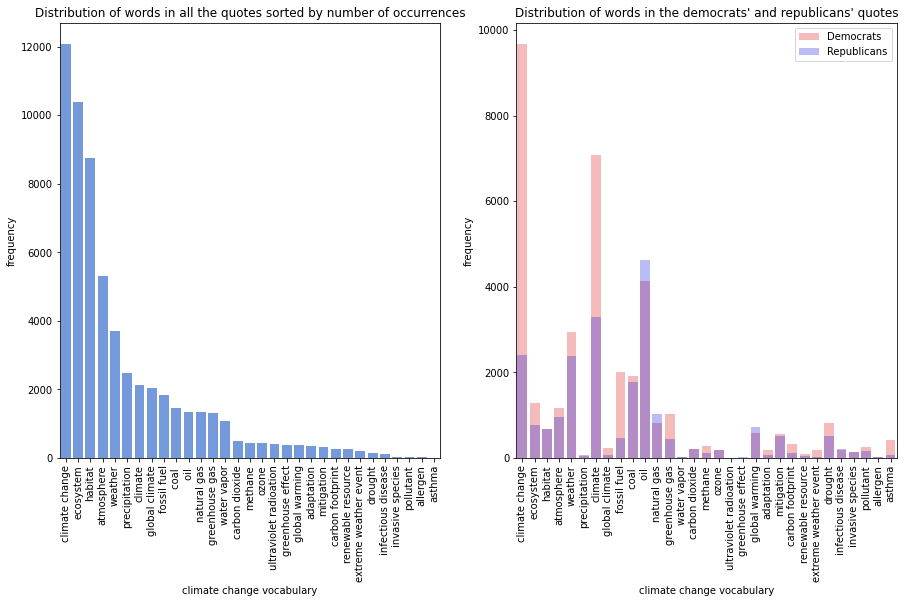

In [229]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

sns.barplot(data=df_climate_change_words, x = 'climate change vocabulary', y='count', label='tot', color='cornflowerblue', ax=ax[0], alpha=1)
sns.barplot(data=df_climate_change_words_dem, x = 'climate change vocabulary', y='count', label='Democrats', ax=ax[1], color='r', alpha=0.3)
sns.barplot(data=df_climate_change_words_rep, x = 'climate change vocabulary', y='count', label='Republicans', ax=ax[1], color='b', alpha=0.3)

ax[0].set_xticklabels(list_climate_change_words, rotation=90)
ax[1].set_xticklabels(list_climate_change_words, rotation=90)

ax[0].set_ylabel('frequency')
ax[1].set_ylabel('frequency')

ax[0].set_title('Distribution of words in all the quotes sorted by number of occurrences')
ax[1].set_title('Distribution of words in the democrats\' and republicans\' quotes')

plt.legend()

In [ ]:
# Add number of quotations per qid to dataframe (Caution: this column is already aggregated)
df_climate_change['quotationCounts'] = df_climate_change.groupby(['qids'])['quoteID'].transform("count")

In [233]:
# TODO: remove in the future
# It is just an example of how a word 'oil' can be not related to climate change
df_climate_change.loc[7681325, 'quotation']

"Our sense is that ISIL is taking its profits basically at the wellhead and, so, while you do have ISIL oil ending up in a variety of different places, that's not really the pressure we want when it comes to stemming the flow of funding -- it really comes down to taking down their infrastructure,"

## **Draft Framework to Handle the Quotes for Next Milestone**

In [ ]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
from nltk.corpus import stopwords
import math
from collections import Counter
import numpy as np
nltk.download('stopwords')
nltk.download('punkt')

stemmer = PorterStemmer()

# Tokenize, stem a document
def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    return " ".join([stemmer.stem(word.lower()) for word in tokens])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
content = df['quotation'] # Quotations
original_documents = [x.strip() for x in content] 
documents = [tokenize(d).split() for d in original_documents]
docs_n_doc_ids = list(zip(range(len(documents)), documents))


In [ ]:
# Create the vocabulary
vocabulary = set([item for sublist in documents for item in sublist])
vocabulary = [word for word in vocabulary if word not in stopwords.words('english')]
vocabulary.sort()

In [ ]:
# Compute IDF, storing idf values in a dictionary
def idf_values(vocabulary, documents):
    idf = {}
    num_documents = len(documents)
    for i, term in enumerate(vocabulary):
        idf[term] = math.log(num_documents/sum(term in document for document in documents), math.e)
    return idf

# Function to generate the vector for a document (with normalisation)
def vectorize(document, vocabulary, idf):
    vector = [0]*len(vocabulary)
    counts = Counter(document)
    max_count = counts.most_common(1)[0][1]
    for i,term in enumerate(vocabulary):
        vector[i] = idf[term] * counts[term]/max_count
    return vector

# Function to compute cosine similarity
def cosine_similarity(v1,v2):
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    if sumxy == 0:
            result = 0
    else:
            result = sumxy/math.sqrt(sumxx*sumyy)
    return result

def vectorize_query(query, vocabulary, idf):
    q = query.split()
    q = [stemmer.stem(w) for w in q]
    query_vector = vectorize(q, vocabulary, idf)
    return query_vector
    
def search_vec(query, k):
    query_vector = vectorize_query(query, vocabulary, idf)
    scores = [[cosine_similarity(query_vector, document_vectors[d]), d] for d in range(len(documents))]
    scores.sort(key=lambda x: -x[0])
    ans = []
    indices = []
    for i in range(min(k,len(original_documents))):
        ans.append(original_documents[scores[i][1]])
        indices.append(scores[i][1])
    return ans, indices, query_vector

# Compute IDF values and vectors
idf = idf_values(vocabulary, documents)
document_vectors = [vectorize(s, vocabulary, idf) for s in documents]

In [ ]:
import operator

doc_vecs = np.transpose(np.array(document_vectors))
h = {}
for i, term in enumerate(vocabulary):
    ha = {}
    for docj in range(len(original_documents)):
        tfidf = doc_vecs[i][docj]
        ha[docj] = tfidf
    sorted_ha = sorted(ha.items(), key=operator.itemgetter(1), reverse=True)
    h[term] = sorted_ha